# <center> <img src="figs/LogoUFSCar.jpg" alt="Logo UFScar" width="110" align="left"/>  <br/> <center>Universidade Federal de São Carlos (UFSCar)<br/><font size="4"> Departamento de Computação, campus Sorocaba</center></font>
</p>

<font size="4"><center><b>Disciplina: Aprendizado de Máquina</b></center></font>
  
<font size="3"><center>Prof. Dr. Tiago A. Almeida</center></font>

## <center>Projeto Final</center>

**Nome**: Anne Mari Suenaga Sakai
**RA**: 822304

**Nome**: Felipe Jun Nishitani
**RA**: 822353


---
## Imports e configuração inicial

Carregamos os módulos necessários, incluindo os scripts do projeto.

In [167]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scripts.preprocessamento import *
from scripts.analise_exploratoria import *
from scripts.experimentos import *
from scripts.analise_resultados import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
## Análise exploratória

Nesta seção, deve ser feita a leitura da base de dados e todas as análises necessárias para interpretar e analisar os dados, tais como:
* Significado de cada atributo
* Medidas descritivas
* Gráficos

A base contém atributos derivados de sensores vestíveis, representando médias, desvios padrão, máximos e mínimos das medições fisiológicas de cada usuário.  
A variável **classe** indica o tipo de esforço (Stress, Aeróbico ou Anaeróbico).

- Os boxplots revelam a presença de outliers em alguns atributos, sugerindo variações extremas entre sujeitos.  
- A matriz de correlação mostra que certos sensores apresentam relações lineares, indicando possíveis atributos redundantes.  
- As distribuições das classes mostram um conjunto relativamente balanceado entre as categorias.


In [168]:
base_path = "dataset"
df = carregar_e_resumir(base_path)


--- Carregando dataset ---

✅ Primeiras linhas do dataset:


,Id,classe,acc_energy,acc_entropy,acc_mag_mean,acc_mag_std,bvp_mean,eda_mean,eda_phasic_mean,eda_std,eda_tonic_mean,hr_mean,hr_std,hrv_rmssd,hrv_sdnn,temp_mean,temp_slope,temp_std
0,U_79201,STRESS,4068.866638,0.820908,63.758315,1.934911,0.020494,2.189811,-0.001937,0.514308,2.191749,98.881952,12.672493,0.045673,0.064240,34.275062,0.000268,0.530891
1,U_56491,ANAEROBIC,4208.309169,0.682113,64.493546,6.992256,0.021553,0.695010,-0.001748,0.666640,0.696758,88.239135,19.887299,0.120337,0.207697,28.352012,-0.000183,0.636924
2,U_94628,ANAEROBIC,4142.529156,0.599849,64.116317,5.623789,0.009702,4.049409,-0.001584,3.069452,4.050993,105.976423,19.883682,0.065383,0.105671,33.945142,0.000137,0.484733
3,U_97819,AEROBIC,4220.643865,0.540780,64.888648,3.179186,0.029392,5.359092,-0.001485,5.371593,5.360577,84.828580,11.066248,0.097257,0.114572,30.958938,0.000147,0.743493
4,U_96956,STRESS,4188.899763,0.666053,64.686163,2.144774,0.001560,0.670497,-0.001202,0.493036,0.671699,79.585647,6.230386,0.056268,0.073907,31.658291,-0.000074,0.358782



📊 Informações gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               75 non-null     object 
 1   classe           75 non-null     object 
 2   acc_energy       75 non-null     float64
 3   acc_entropy      75 non-null     float64
 4   acc_mag_mean     75 non-null     float64
 5   acc_mag_std      75 non-null     float64
 6   bvp_mean         75 non-null     float64
 7   eda_mean         75 non-null     float64
 8   eda_phasic_mean  75 non-null     float64
 9   eda_std          75 non-null     float64
 10  eda_tonic_mean   75 non-null     float64
 11  hr_mean          75 non-null     float64
 12  hr_std           75 non-null     float64
 13  hrv_rmssd        73 non-null     float64
 14  hrv_sdnn         73 non-null     float64
 15  temp_mean        74 non-null     float64
 16  temp_slope       74 non-null     float64


,Id,classe,acc_energy,acc_entropy,acc_mag_mean,acc_mag_std,bvp_mean,eda_mean,eda_phasic_mean,eda_std,eda_tonic_mean,hr_mean,hr_std,hrv_rmssd,hrv_sdnn,temp_mean,temp_slope,temp_std
count,75,75,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,73.000000,73.000000,74.000000,74.000000,74.000000
unique,75,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,U_96705,ANAEROBIC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,4300.559844,0.838452,64.888560,3.955418,0.003332,6.680819,-0.002192,3.823965,6.683011,93.882473,16.821741,0.063188,0.100189,32.369715,0.000010,0.631250
std,NaN,NaN,1675.109339,0.363718,8.257245,2.685613,0.011656,8.233190,0.001327,4.142668,8.233274,16.155851,9.073584,0.028234,0.040062,1.796072,0.000294,0.418633
min,NaN,NaN,3768.045932,0.540780,61.359069,1.076043,-0.032294,0.238126,-0.010193,0.056461,0.239361,62.228672,4.655147,0.027499,0.036318,25.295883,-0.000937,0.035736
25%,NaN,NaN,4045.069770,0.638203,63.529587,2.117531,-0.002810,1.361458,-0.002768,0.918854,1.364135,81.933728,9.794185,0.043321,0.069818,31.496474,-0.000141,0.317925
50%,NaN,NaN,4143.999590,0.710770,64.276497,3.431269,0.003114,3.690940,-0.001873,2.595732,3.692786,92.051647,16.005342,0.053799,0.094895,32.454401,0.000059,0.552936
75%,NaN,NaN,4206.539459,0.898641,64.712951,5.025788,0.009903,8.649052,-0.001390,4.991839,8.651783,105.350650,21.402240,0.073565,0.123224,33.580486,0.000167,0.868366



--- Medidas Descritivas ---

📦 Distribuição das classes:


ANAEROBIC    28
STRESS       25
AEROBIC      22
Name: classe, dtype: int64

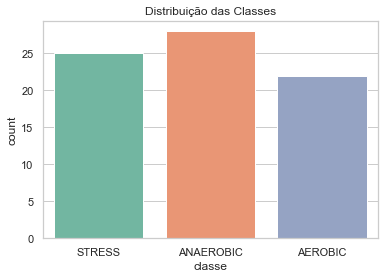


🚨 Valores ausentes por coluna:


Id                 0
classe             0
acc_energy         0
acc_entropy        0
acc_mag_mean       0
acc_mag_std        0
bvp_mean           0
eda_mean           0
eda_phasic_mean    0
eda_std            0
eda_tonic_mean     0
hr_mean            0
hr_std             0
hrv_rmssd          2
hrv_sdnn           2
temp_mean          1
temp_slope         1
temp_std           1
dtype: int64

In [169]:
# ==========================================================
# ANÁLISE EXPLORATÓRIA - Medidas descritivas
# ==========================================================
medidas_descritivas(df)


--- Boxplots e Histogramas ---


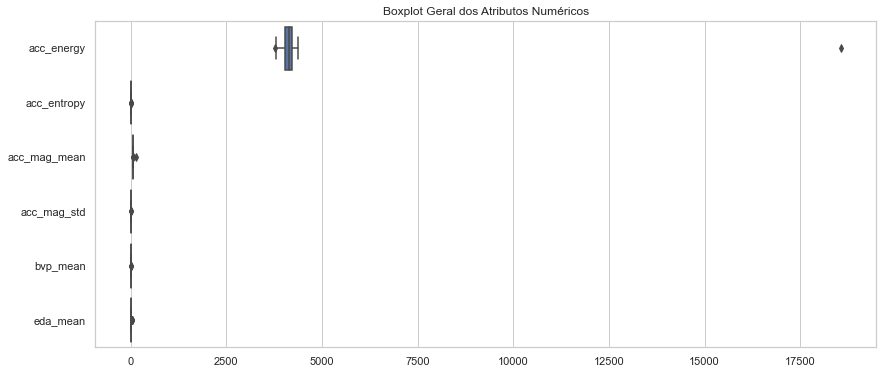

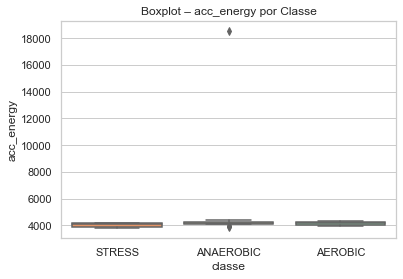

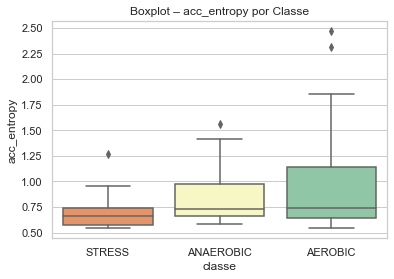

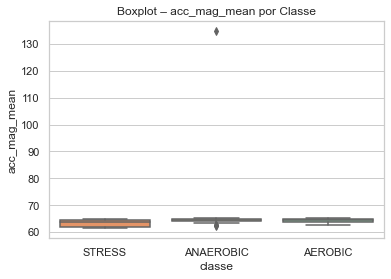

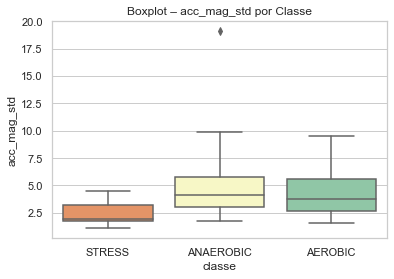

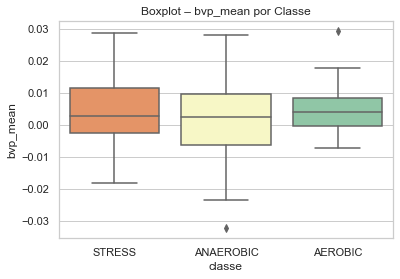

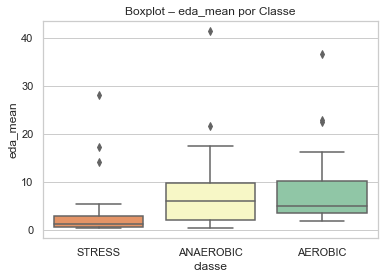

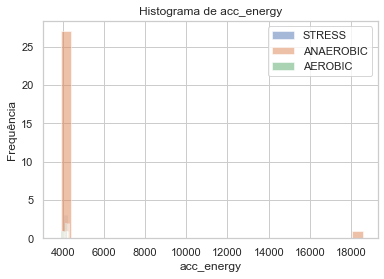

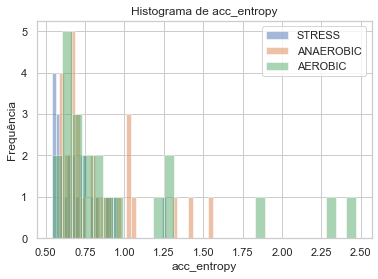

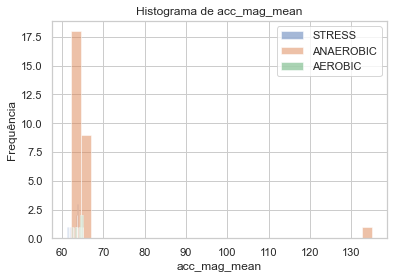

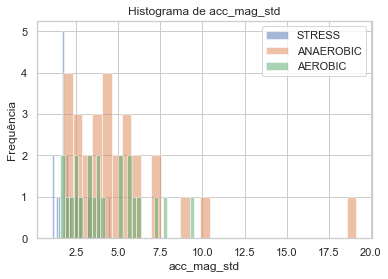

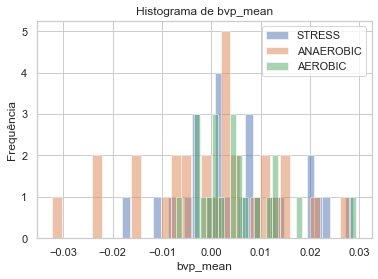

In [170]:
# ==========================================================
# ANÁLISE EXPLORATÓRIA - Boxplots e Histogramas
# ==========================================================
from scripts.analise_exploratoria import boxplots_e_histogramas
boxplots_e_histogramas(df)


--- Matriz de Correlação ---


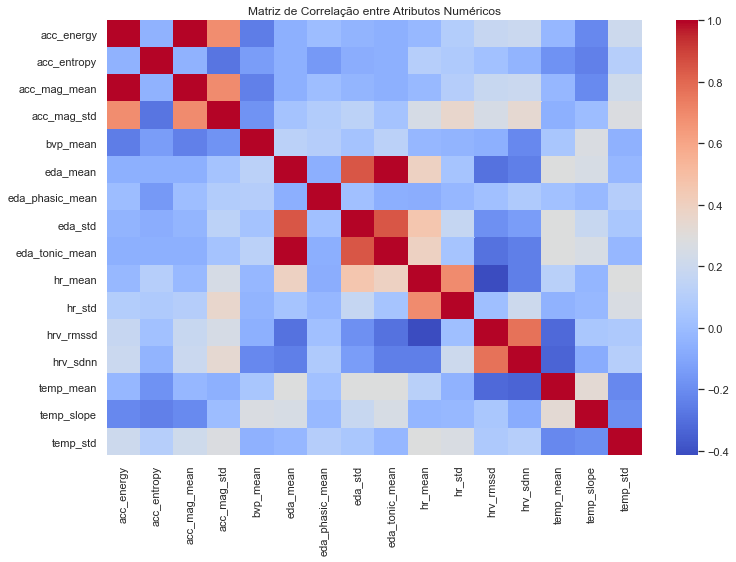


🔗 Maiores correlações:


eda_mean      eda_tonic_mean    1.000000
acc_energy    acc_mag_mean      0.999056
eda_mean      eda_std           0.849207
eda_std       eda_tonic_mean    0.849195
hrv_rmssd     hrv_sdnn          0.769044
hr_mean       hr_std            0.695529
acc_mag_mean  acc_mag_std       0.692277
acc_energy    acc_mag_std       0.690494
eda_std       hr_mean           0.463673
hr_mean       hrv_rmssd        -0.414861
dtype: float64

In [171]:
# ==========================================================
# ANÁLISE EXPLORATÓRIA - Correlação entre atributos
# ==========================================================
correlacao_atributos(df)



--- Pairplot Amostrado ---
Gerando pairplot com 75 amostras e 5 atributos...


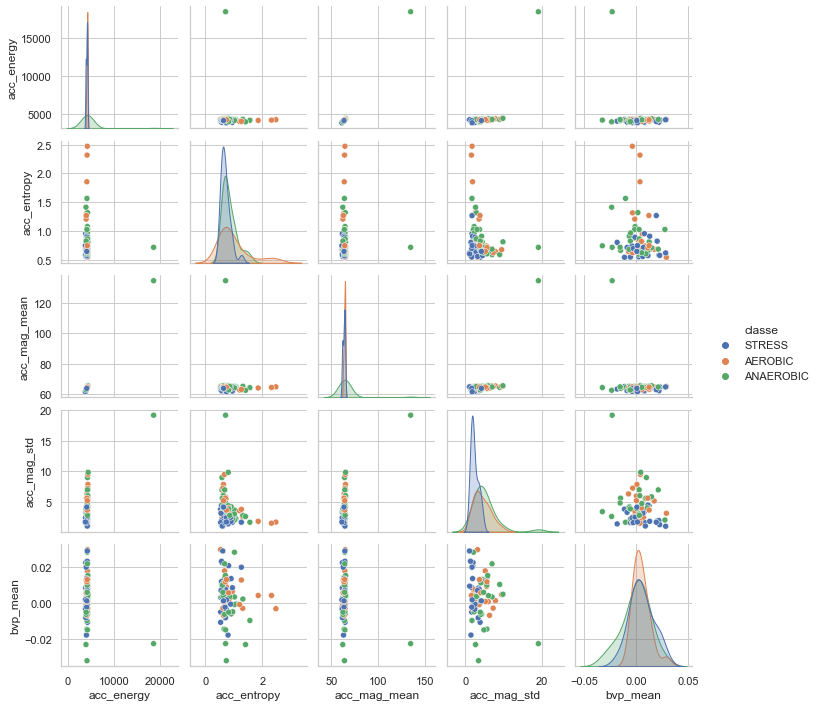

In [172]:
# ==========================================================
# ANÁLISE EXPLORATÓRIA - Pairplot amostrado
# ==========================================================
pairplot_amostrado(df)


Foram plotadas as séries agregadas de cada sensor (HR, HRV, EDA, ACC e temperatura) ao longo das amostras. Esses gráficos permitem identificar padrões globais entre os participantes, como variações amplas na atividade eletrodérmica e na frequência cardíaca, frequentemente associadas a estados de estresse, bem como valores mais elevados de aceleração média em casos de exercícios aeróbicos e anaeróbicos.

TEXTO DE INTERPRETACAO DOS GRAFICOS MAIS IMPORTANTES 
(exemplo: Os gráficos temporais permitiram observar tendências gerais nos sinais fisiológicos. Picos repentinos em HR e ACC indicam episódios de esforço físico, enquanto aumentos abruptos em EDA refletem respostas de estresse agudo. Já quedas graduais em temperatura são consistentes com a literatura sobre vasoconstrição induzida por estresse. A variabilidade entre amostras também revelou perfis distintos de ativação fisiológica entre os participantes.)
(como analisar abaixo)


⭐ 1) Como interpretar gráficos temporais (plot_series_temporais)

Um gráfico temporal no seu caso não é o tempo real da coleta, mas o conjunto de amostras ordenadas (usuários). Mesmo assim, ele revela padrões fisiológicos úteis.

✔ O que observar e como interpretar
1. Picos (valores muito altos repentinamente)
📌 Em HR (Frequência Cardíaca):

Picos altos → esforço físico intenso ou resposta de estresse.

Se associados a baixo ACC → mais estresse do que exercício.

📌 Em EDA (Condutância da pele):

Picos de EDA são o melhor indicador de estresse.

Estão associados a sudorese simpática.

📌 Em ACC:

Picos indicam movimentos bruscos, como corrida ou exercícios anaeróbicos.

2. Quedas bruscas (valores que despencam)
📌 Em TEMP:

Quedas suaves podem indicar estresse (vasoconstrição periférica).

Quedas rápidas podem indicar sensor soltando (ruído).

📌 Em HR:

Quedas grandes podem significar término de exercício.

3. Tendências (crescimento ou queda gradual)
📌 HR subindo gradualmente:

Indica ativação do sistema cardiovascular, geralmente exercício prolongado.

📌 EDA subindo ao longo do gráfico:

Indica acúmulo de ativação mental → estresse sustentado.

📌 TEMP caindo lentamente:

Sinal clássico em estudos de estresse.

4. Variação (sinal “instável”, oscilando muito)
📌 HRV baixa (RMSSD baixo) + alta variabilidade de HR

→ organismo em estado de alerta / estresse.

📌 ACC variando muito:

→ exercícios intermitentes.

📌 EDA “tremido”:

→ possível ruído ou muita excitação simpática.

5. Flat lines (valores constantes demais)

Isso normalmente indica sensor com problema, exceto:

HRV pode ser naturalmente baixo em certas pessoas.

TEMP pode ser estável em repouso.


--- Séries Temporais ---


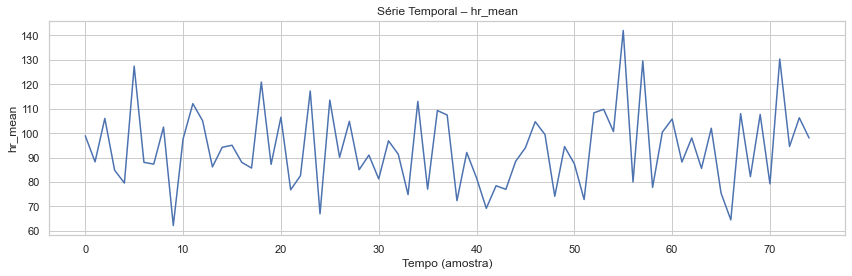

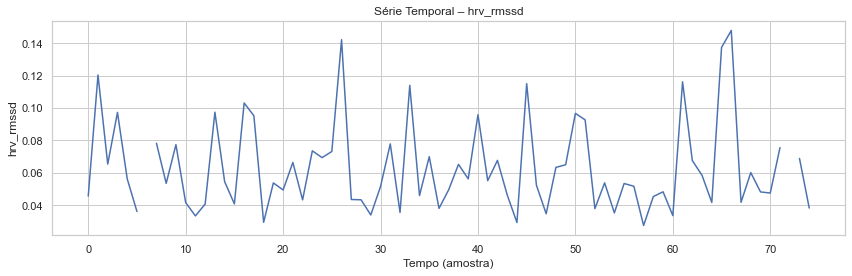

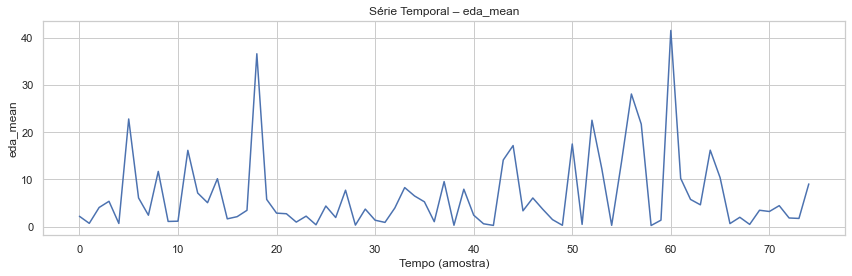

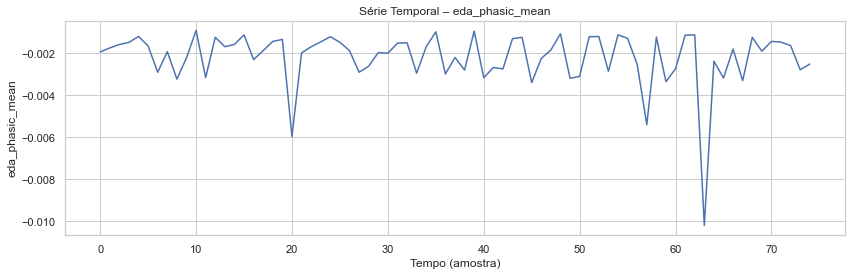

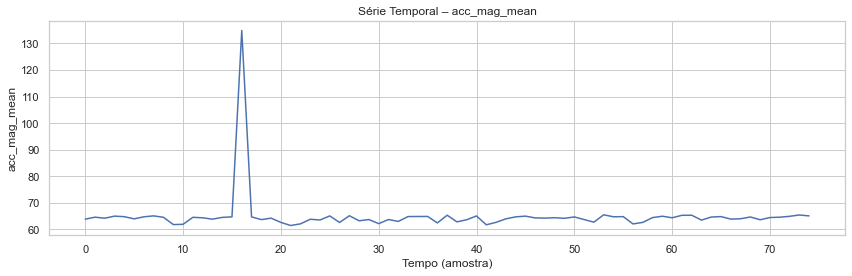

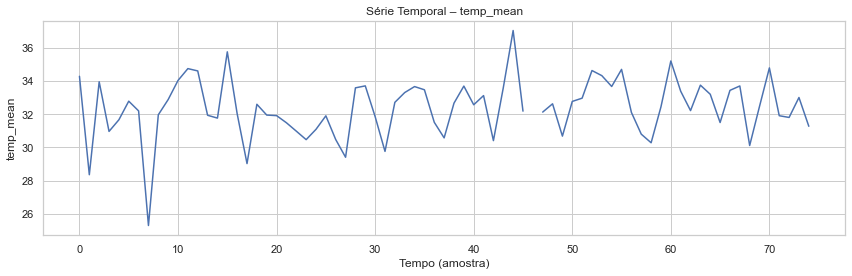

In [173]:
plot_series_temporais(df, [
    "hr_mean",
    "hrv_rmssd",
    "eda_mean",
    "eda_phasic_mean",
    "acc_mag_mean",
    "temp_mean"
])


Também foram analisadas relações entre pares de sensores, como HR × EDA, ACC × HR e HRV × EDA. Os gráficos de dispersão revelam separações naturais entre os estados fisiológicos: indivíduos em condição de estresse tendem a apresentar EDA elevada combinada com RMSSD reduzido, enquanto atividades aeróbicas e anaeróbicas apresentam maior magnitude de aceleração e frequência cardíaca, porém com diferentes assinaturas eletrodérmicas.

TEXTO COM INTERPRETACAO DOS GRAFICOS!!! (exemplo: Os gráficos de dispersão mostraram relações importantes entre sensores. O par HR × EDA evidenciou um agrupamento de indivíduos com ambos os valores elevados, sugerindo estados de alto arousal fisiológico, típicos de estresse. A relação inversa entre HRV e EDA phasic indica diminuição da atividade parassimpática em situações de estresse. Já ACC × HR ajudou a diferenciar claramente atividades físicas de episódios de estresse, já que esforço físico tende a aumentar simultaneamente aceleração e frequência cardíaca.)

⭐ 2) Como interpretar scatter plots (scatter_duplo)

Scatter plots são ainda mais importantes, porque mostram relações entre variáveis.

✔ O que procurar:
1. Clusters (agrupamentos visíveis)
✔ Se HR_mean × EDA_mean gera três nuvens separadas:

Cluster HR alto + EDA alto → STRESS

Cluster HR alto + ACC alto → EXERCISE (AEROBIC/ANAEROBIC)

Cluster HR baixo + EDA baixo → repouso / baseline

Esse é o gráfico mais poderoso da análise.

2. Correlação (linha inclinada)
📌 HR_mean vs EDA_mean com inclinação positiva

Quanto maior a ativação simpática, maior HR e EDA.

Indica arousal fisiológico.

📌 HRV vs EDA_phasic com inclinação negativa

Quanto maior o estresse:

HRV ↓

EDA ↑

Esse padrão é amplamente comprovado em neurofisiologia.

3. Pontos muito distantes do resto (outliers)

Usado para:

identificar erros de sensor

indivíduos muito diferentes (podem distorcer o modelo)

4. Faixas vazias (sem pontos)

Se no scatter HR × ACC aparecerem faixas vazias:

você tem faixas de movimento inexistentes, indicando que certas atividades não ocorreram.

5. Distribuição desigual dos pontos
📌 Pontos concentrados em uma região:

o dataset é desbalanceado naquela variável

ajuda a entender por que alguns modelos têm dificuldade

6. Curvaturas (relação não linear)

Exemplo:

Se ACC aumenta, HR aumenta até um limite, e depois estabiliza:

→ relação não linear → SVM RBF ou Random Forest podem capturar melhor que Regressão Logística.

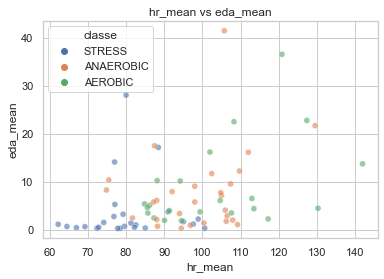

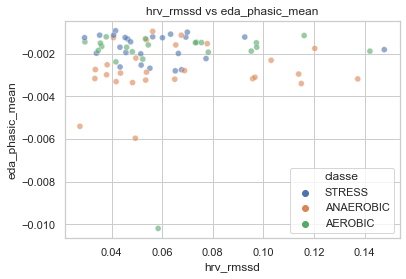

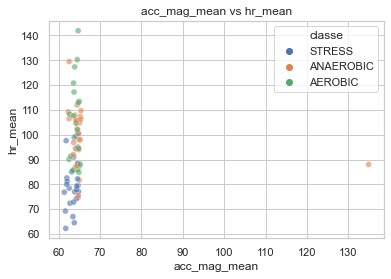

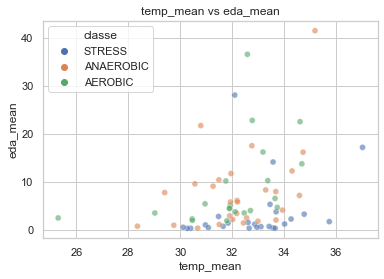

In [174]:
scatter_duplo(df, "hr_mean", "eda_mean")
scatter_duplo(df, "hrv_rmssd", "eda_phasic_mean")
scatter_duplo(df, "acc_mag_mean", "hr_mean")
scatter_duplo(df, "temp_mean", "eda_mean")


---
## Pré-processamento

Nesta seção, as funções da etapa de pré-processamento dos dados devem ser implementadas e aplicadas (se necessário).

In [175]:
# ==========================================================
# PRÉ-PROCESSAMENTO - Tratamento de faltantes e outliers
# ==========================================================

#  nao ta precisando pq nn tem valor ausente
df_limpo = tratar_valores_ausentes(df)
df_limpo = remover_atributos_redundantes(df_limpo)
df_limpo = aplicar_transformacao_log(df_limpo)


# # ⭐ POR QUE IQR NÃO FUNCIONA PARA SINAIS FISIOLÓGICOS?
# Porque IQR assume distribuição simétrica e estável, o que não ocorre:
# EDA → altamente assimétrico
# HRV → distribuição longa
# ACC → altamente dependente de atividade
# TEMP → muito estável, punindo levemente qualquer variação
# BVP → ruído natural que parece outlier
# ➡️ IQR gera muitos falsos positivos.
# ➡️ E a regra .any(axis=1) remove a linha inteira se 1 atributo for outlier.

df_limpo = limitar_outliers_zscore(df_limpo, zmax=3.0)
df_limpo = criar_features_interacao(df_limpo)

df_limpo.head()

--- Atributos removidos: ['eda_tonic_mean', 'acc_mag_mean'] ---
--- Aplicando Log1p em: ['acc_energy', 'acc_mag_std', 'acc_entropy', 'eda_mean', 'eda_phasic_mean'] ---
--- Features de interação criadas ---


,Id,classe,acc_energy,acc_entropy,acc_mag_std,bvp_mean,eda_mean,eda_phasic_mean,eda_std,hr_mean,hr_std,hrv_rmssd,hrv_sdnn,temp_mean,temp_slope,temp_std,inter_hr_acc_ratio,inter_eda_temp_mult,inter_hrv_eda
0,U_79201,STRESS,8.311366,0.599335,1.076677,0.020494,1.159962,-0.001939,0.514308,98.881952,12.672493,0.045673,0.064240,34.275062,0.000268,0.530891,10.619490,39.757761,0.023490
1,U_56491,ANAEROBIC,8.345054,0.520051,2.078473,0.021553,0.527689,-0.001749,0.666640,88.239135,19.887299,0.120337,0.207697,28.352012,-0.000183,0.636924,9.442336,14.961036,0.080222
2,U_94628,ANAEROBIC,8.329303,0.469909,1.890668,0.009702,1.619271,-0.001585,3.069452,105.976423,19.883682,0.065383,0.105671,33.945142,0.000137,0.484733,11.359522,54.966390,0.200691
3,U_97819,AEROBIC,8.347980,0.432289,1.430117,0.029392,1.849886,-0.001486,5.371593,84.828580,11.066248,0.097257,0.114572,30.958938,0.000147,0.743493,9.074536,57.270495,0.522423
4,U_96956,STRESS,8.340432,0.510457,1.145742,0.001560,0.513121,-0.001202,0.493036,79.585647,6.230386,0.056268,0.073907,31.658291,-0.000074,0.358782,8.520553,16.244545,0.027742


In [176]:
# ==========================================================
# PRÉ-PROCESSAMENTO - Carregar os dados de teste e tratar igual ao treino
# ==========================================================
df_test = gerar_dataset(base_path, mode="test")
df_test = tratar_valores_ausentes(df_test)
df_test = remover_atributos_redundantes(df_test)
df_test = aplicar_transformacao_log(df_test)
df_test = limitar_outliers_zscore(df_test, zmax=3.0)
df_test = criar_features_interacao(df_test)


--- Atributos removidos: ['eda_tonic_mean', 'acc_mag_mean'] ---
--- Aplicando Log1p em: ['acc_energy', 'acc_mag_std', 'acc_entropy', 'eda_mean', 'eda_phasic_mean'] ---
--- Features de interação criadas ---


In [177]:
# ==========================================================
# PRÉ-PROCESSAMENTO - Preparar dados para os modelos
# ==========================================================
X_base, y_base, X_test, test_ids, label_encoder, scaler = preparar_dados(
    df_limpo,
    df_test
)

X_base.shape, X_test.shape

((75, 17), (25, 17))

In [178]:
from sklearn.model_selection import train_test_split

# dividir treino em treino/validação
X_train, X_val, y_train, y_val = train_test_split(
    X_base, y_base, 
    test_size=0.2,
    random_state=42,
    stratify=y_base
)

X_train.shape, X_val.shape, y_train.shape, y_val.shape


((60, 17), (15, 17), (60,), (15,))


--- Séries Temporais ---


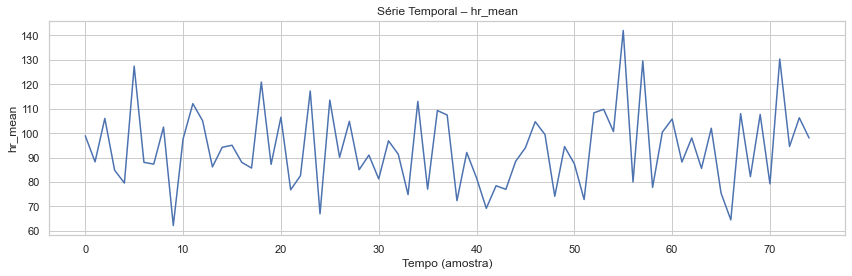

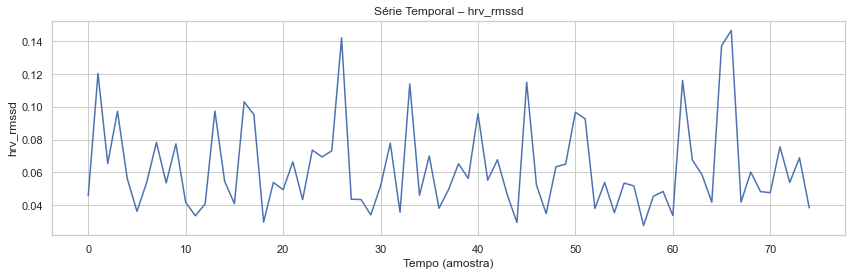

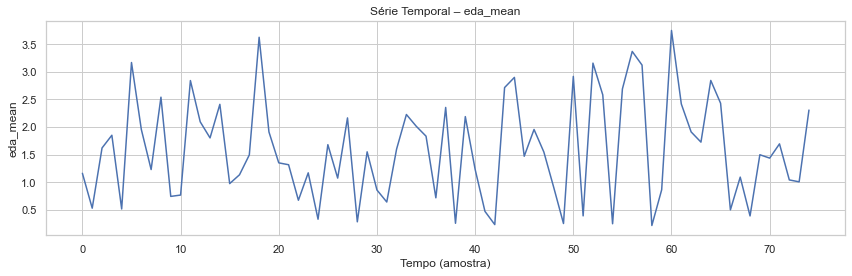

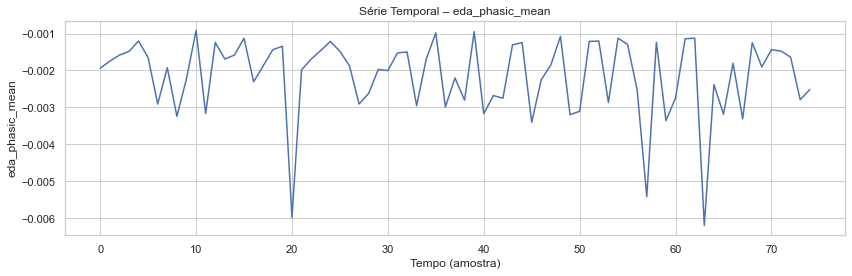

⚠️ Coluna acc_mag_mean não encontrada.


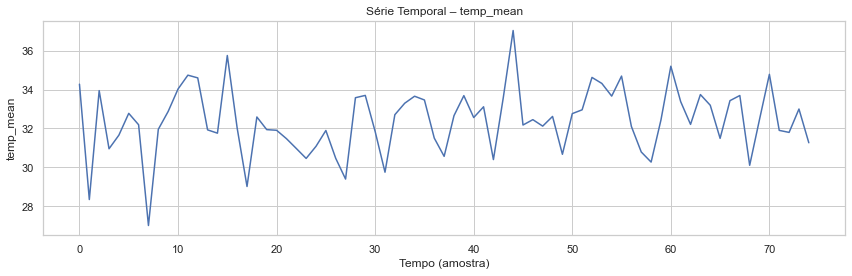

In [179]:
plot_series_temporais(df_limpo, [
    "hr_mean",
    "hrv_rmssd",
    "eda_mean",
    "eda_phasic_mean",
    "acc_mag_mean",
    "temp_mean"
])


---
## Experimento

Nesta seção, o experimento deve ser conduzido, utilizando os protocolos experimentais padrões e testando diferentes modelos.

Treinamos os seguintes modelos:
- KNN  
- Naive Bayes  
- Regressão Logística  
- Rede Neural (MLP)  
- SVM  
- Random Forest

In [180]:
# ==========================================================
# EXPERIMENTOS - Treinamento de modelos baseline
# ==========================================================
model_knn = treinar_knn(X_train, y_train)
model_nb = treinar_naive_bayes(X_train, y_train)
model_lr = treinar_regressao_logistica(X_train, y_train)
model_mlp = treinar_rede_neural(X_train, y_train)
model_svm = treinar_svm(X_train, y_train)
model_rf = treinar_random_forest(X_train, y_train)
model_xgb = treinar_xgboost(X_train, y_train)

modelos_baseline = {
    "KNN": model_knn,
    "Naive Bayes": model_nb,
    "Regressão Logística": model_lr,
    "MLP (Simples)": model_mlp,
    "SVM (Simples)": model_svm,
    "Random Forest (Simples)": model_rf,
    "XGBoost (Simples)": model_xgb
}

modelos_baseline


--- Treinando KNN (k=7) ---

--- Treinando Naive Bayes (Gaussian) ---

--- Treinando Regressão Logística ---

--- Treinando Rede Neural (MLP) ---

--- Treinando SVM (RBF) ---

--- Treinando Random Forest ---

--- Treinando XGBoost (baseline) ---


{'KNN': KNeighborsClassifier(n_neighbors=7),
 'Naive Bayes': GaussianNB(),
 'Regressão Logística': LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42),
 'MLP (Simples)': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42),
 'SVM (Simples)': SVC(probability=True, random_state=42),
 'Random Forest (Simples)': RandomForestClassifier(n_jobs=1, random_state=42),
 'XGBoost (Simples)': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.8, eval_metric='mlogloss',
               gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', learning_rate=0.05, max_delta_step=0,
               max_depth=5, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=200, n_jobs=-1,
               num_parallel_tree=1, objective='multi:softprob', random_state=42,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=None, su

In [181]:
# ==========================================================
# EXPERIMENTOS - Validação cruzada (baseline)
# ==========================================================

print("=== Validação Cruzada (5-fold) - Baselines ===\n")

for nome, modelo in modelos_baseline.items():
    print(f"\nModelo: {nome}")
    avaliar_com_crossval(modelo, X_train, y_train, cv=5)


=== Validação Cruzada (5-fold) - Baselines ===


Modelo: KNN

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.66666667 0.66666667 0.66666667 0.75       0.58333333]
Média: 0.6666666666666667
Desvio: 0.05270462766947298

Modelo: Naive Bayes

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.66666667 0.58333333 0.66666667 0.58333333 0.66666667]
Média: 0.6333333333333333
Desvio: 0.04082482904638627

Modelo: Regressão Logística

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.75       0.75       0.66666667 0.66666667 0.83333333]
Média: 0.7333333333333333
Desvio: 0.062360956446232386

Modelo: MLP (Simples)

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.58333333 0.66666667 0.75       0.91666667 0.75      ]
Média: 0.7333333333333333
Desvio: 0.11055415967851331

Modelo: SVM (Simples)

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.58333333 0.66666667 0.83333333 0.66666667 0.75    

In [182]:
# ==========================================================
# EXPERIMENTOS - SVM Otimizado (Grid Search)
# ==========================================================

print("\n=== Treinando SVM Otimizado ===")
model_svm_best = treinar_svm_otimizado(X_train, y_train)
model_svm_best



=== Treinando SVM Otimizado ===

=== Ajustando SVM com GridSearchCV ===
Melhores parâmetros: {'C': 5, 'gamma': 0.01, 'kernel': 'rbf'}
Melhor score médio CV: 0.8166666666666668


SVC(C=5, gamma=0.01, probability=True, random_state=42)

In [183]:
# ==========================================================
# EXPERIMENTOS - MLP Otimizado (Grid Search)
# ==========================================================

print("\n=== Treinando MLP Otimizado ===")
model_mlp_best = treinar_mlp_otimizado(X_train, y_train)
model_mlp_best



=== Treinando MLP Otimizado ===

=== Ajustando MLP com GridSearchCV ===
Melhores parâmetros: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.001}
Melhor score CV: 0.75


MLPClassifier(hidden_layer_sizes=(64,), max_iter=600, random_state=42)

In [184]:
# ==========================================================
# EXPERIMENTOS - Random Forest Otimizado (Grid Search)
# ==========================================================

print("\n=== Treinando Random Forest Otimizado ===")
model_rf_best = treinar_rf_otimizado(X_train, y_train)
model_rf_best



=== Treinando Random Forest Otimizado ===

=== Ajustando Random Forest com GridSearchCV ===
Melhores parâmetros: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Melhor score RF CV: 0.8166666666666667


RandomForestClassifier(min_samples_leaf=2, min_samples_split=5, n_estimators=50,
                       n_jobs=-1, random_state=42)

In [185]:
# ==========================================================
# EXPERIMENTOS - XGBoost Otimizado (Grid Search)
# ==========================================================

print("\n=== Treinando XGBoost Otimizado ===")
model_xgb_best = treinar_xgboost_otimizado(X_train, y_train)
model_xgb_best



=== Treinando XGBoost Otimizado ===

=== Ajustando XGBoost (RandomizedSearchCV + Early Stopping) ===
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 185 out of 200 | elapsed:    3.1s remaining:    0.3s


Melhores parâmetros: {'subsample': 0.6, 'reg_lambda': 3, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
Melhor score CV: 0.8


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.4s finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=9, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=42,
              reg_alpha=0.1, reg_lambda=3, scale_pos_weight=None, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [186]:
# ==========================================================
# EXPERIMENTOS - Validação cruzada (modelos otimizados)
# ==========================================================

print("=== Validação Cruzada - Modelos Otimizados ===\n")

print("\nSVM Otimizado:")
avaliar_com_crossval(model_svm_best, X_train, y_train)

print("\nMLP Otimizado:")
avaliar_com_crossval(model_mlp_best, X_train, y_train)

print("\nRF Otimizado:")
avaliar_com_crossval(model_rf_best, X_train, y_train)

print("\nXGB Otimizado:")
avaliar_com_crossval(model_xgb_best, X_train, y_train)

=== Validação Cruzada - Modelos Otimizados ===


SVM Otimizado:

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.66666667 0.83333333 0.75       0.83333333 1.        ]
Média: 0.8166666666666668
Desvio: 0.11055415967851334

MLP Otimizado:

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.75       0.66666667 0.75       0.75       0.83333333]
Média: 0.75
Desvio: 0.052704627669473016

RF Otimizado:

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.75       0.66666667 0.91666667 0.83333333 0.91666667]
Média: 0.8166666666666667
Desvio: 0.097182531580755

XGB Otimizado:

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.75       0.75       0.83333333 0.66666667 1.        ]
Média: 0.8
Desvio: 0.11303883305208781


array([0.75      , 0.75      , 0.83333333, 0.66666667, 1.        ])

In [187]:
# ==========================================================
# EXPERIMENTOS - Comparação geral (baseline + otimizados)
# ==========================================================

modelos = {
    "KNN": model_knn,
    "Naive Bayes": model_nb,
    "Regressão Logística": model_lr,
    "MLP Simples": model_mlp,
    "SVM Simples": model_svm,
    "Random Forest Simples": model_rf,
    "XGBoost Simples": model_xgb,
    "MLP Otimizado": model_mlp_best,
    "SVM Otimizado": model_svm_best,
    "Random Forest Otimizado": model_rf_best,
    "XGBoost Otimizado": model_xgb_best
}

resultados = {}

for nome, modelo in modelos.items():
    print(f"\nModelo: {nome}")
    scores = avaliar_com_crossval(modelo, X_train, y_train)
    resultados[nome] = scores.mean()

print("\n\n=== Médias de Acurácia ===")
resultados



Modelo: KNN

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.66666667 0.66666667 0.66666667 0.75       0.58333333]
Média: 0.6666666666666667
Desvio: 0.05270462766947298

Modelo: Naive Bayes

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.66666667 0.58333333 0.66666667 0.58333333 0.66666667]
Média: 0.6333333333333333
Desvio: 0.04082482904638627

Modelo: Regressão Logística

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.75       0.75       0.66666667 0.66666667 0.83333333]
Média: 0.7333333333333333
Desvio: 0.062360956446232386

Modelo: MLP Simples

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.58333333 0.66666667 0.75       0.91666667 0.75      ]
Média: 0.7333333333333333
Desvio: 0.11055415967851331

Modelo: SVM Simples

--- Avaliação com Cross-Validation (5-fold) ---
Scores individuais: [0.58333333 0.66666667 0.83333333 0.66666667 0.75      ]
Média: 0.7
Desvio: 0.08498365855987976

Modelo: 

{'KNN': 0.6666666666666667,
 'Naive Bayes': 0.6333333333333333,
 'Regressão Logística': 0.7333333333333333,
 'MLP Simples': 0.7333333333333333,
 'SVM Simples': 0.7,
 'Random Forest Simples': 0.75,
 'XGBoost Simples': 0.7333333333333333,
 'MLP Otimizado': 0.75,
 'SVM Otimizado': 0.8166666666666668,
 'Random Forest Otimizado': 0.8166666666666667,
 'XGBoost Otimizado': 0.8}

---
## Análise dos Resultados

Nesta seção, os resultados devem ser exibidos através de tabelas e gráficos, comparados e profundamente analisados.

Para comparamos o desempenho dos modelos usamos:
- Métricas macro  
- Matriz de confusão  
- Curvas de aprendizado  
- Teste de McNemar para significância estatística  


In [188]:
# ==========================================================
# ANÁLISE DOS RESULTADOS - Avaliação agregada
# ==========================================================
df_metrics = avaliar_modelos_dict(modelos, X_train, y_train)
df_metrics

,accuracy,precision_macro,recall_macro,f1_macro
modelo,,,,
KNN,0.816667,0.813952,0.819865,0.814720
Naive Bayes,0.800000,0.808612,0.803199,0.802022
Regressão Logística,0.900000,0.902778,0.895623,0.897698
MLP Simples,1.000000,1.000000,1.000000,1.000000
SVM Simples,0.916667,0.938272,0.907407,0.912223
Random Forest Simples,1.000000,1.000000,1.000000,1.000000
XGBoost Simples,1.000000,1.000000,1.000000,1.000000
MLP Otimizado,1.000000,1.000000,1.000000,1.000000
SVM Otimizado,0.900000,0.928571,0.888889,0.893333


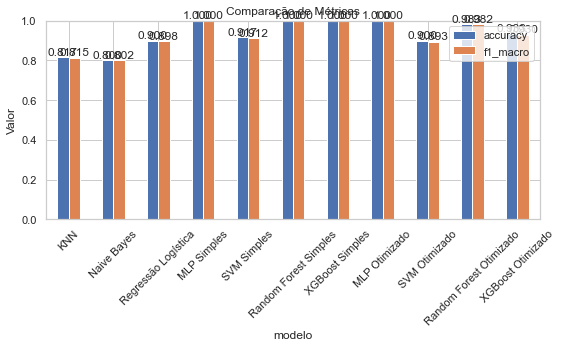

In [189]:
# ==========================================================
# ANÁLISE DOS RESULTADOS - Gráfico de barras das métricas principais
# ==========================================================
plot_metric_bars(df_metrics, metrics=("accuracy", "f1_macro"))

In [190]:
# ==========================================================
# ANÁLISE DOS RESULTADOS - Classification Reports completos
# ==========================================================
mostrar_classification_reports(modelos, X_val, y_val)


=== Classification Report: KNN ===
              precision    recall  f1-score   support

           0       0.17      0.25      0.20         4
           1       0.33      0.17      0.22         6
           2       0.83      1.00      0.91         5

    accuracy                           0.47        15
   macro avg       0.44      0.47      0.44        15
weighted avg       0.46      0.47      0.45        15


=== Classification Report: Naive Bayes ===
              precision    recall  f1-score   support

           0       0.20      0.25      0.22         4
           1       0.50      0.33      0.40         6
           2       0.83      1.00      0.91         5

    accuracy                           0.53        15
   macro avg       0.51      0.53      0.51        15
weighted avg       0.53      0.53      0.52        15


=== Classification Report: Regressão Logística ===
              precision    recall  f1-score   support

           0       0.25      0.25      0.25        

In [191]:
# ==========================================================
# ANÁLISE DOS RESULTADOS - Tabela detalhada por classe (para o melhor modelo)
# ==========================================================
modelo_principal = modelos["Random Forest Otimizado"]  
tabela_por_classe(modelo_principal, X_val, y_val)


,precision,recall,f1,support
0,0.750000,0.750000,0.750000,4
1,1.000000,0.666667,0.800000,6
2,0.714286,1.000000,0.833333,5


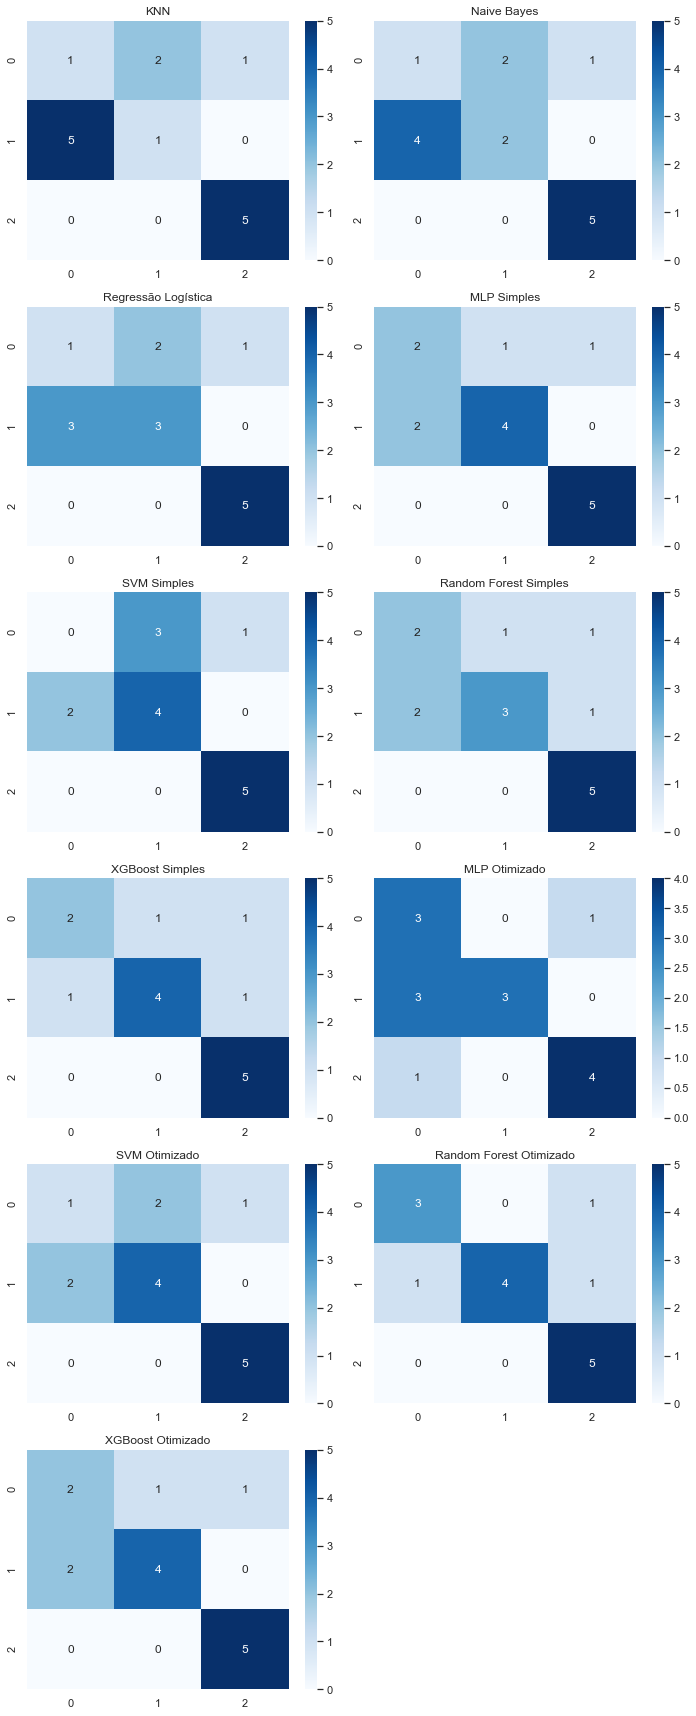

In [192]:
# ==========================================================
# ANÁLISE DOS RESULTADOS - Matrizes de confusão de todos os modelos
# ==========================================================
comparar_modelos_plot_confusao(
    modelos,
    X_val,
    y_val,
    labels=sorted(set(y_val)),
    normalize=False,
    max_per_row=2
)


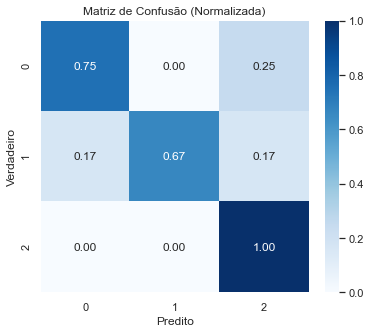

In [193]:
# =========================
# ANÁLISE DOS RESULTADOS - Matriz de confusão normalizada do melhor modelo
# =========================
plot_confusion_matrix_model(
    modelo_principal,
    X_val, y_val,
    labels=sorted(set(y_val)),
    normalize=True
)


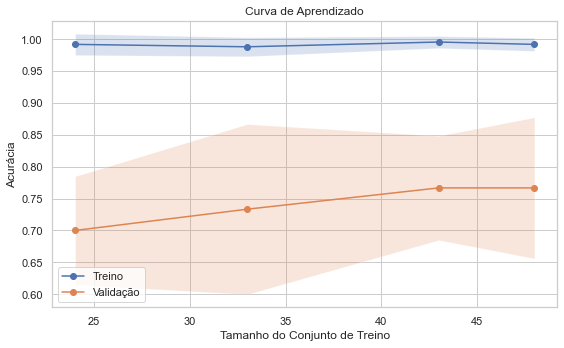

In [194]:
# =========================
# ANÁLISE DOS RESULTADOS - Curva de aprendizado para o melhor modelo
# =========================
from sklearn.model_selection import StratifiedKFold

cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve_model(
    modelo_principal, 
    X_train, y_train,
    cv=cv5,
    train_sizes=[0.5, 0.7, 0.9, 1.0]
)


In [195]:
# =========================
# ANÁLISE DOS RESULTADOS - Teste de McNemar (entre dois modelos)
# =========================
modelo_a = modelos["SVM Otimizado"]
modelo_b = modelos["MLP Otimizado"]

pvalor = teste_mcnemar(modelo_a, modelo_b, X_val, y_val)
print("p-valor McNemar:", pvalor)

if pvalor < 0.05:
    print("Diferença estatisticamente significativa!")
else:
    print("Não há diferença estatisticamente significativa.")

p-valor McNemar: 0.6170750774519739
Não há diferença estatisticamente significativa.


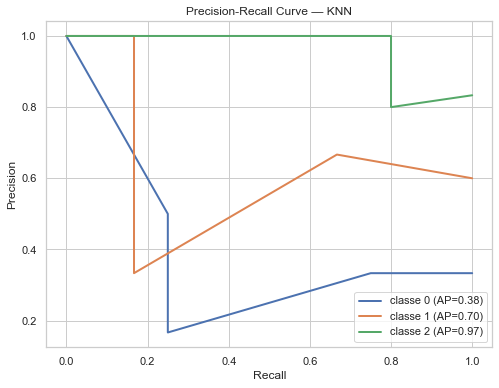

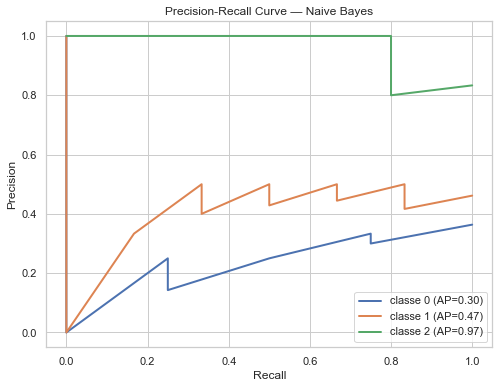

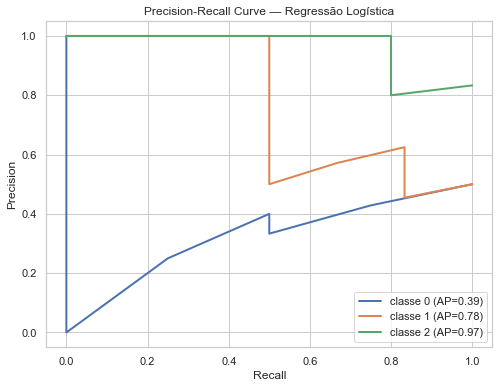

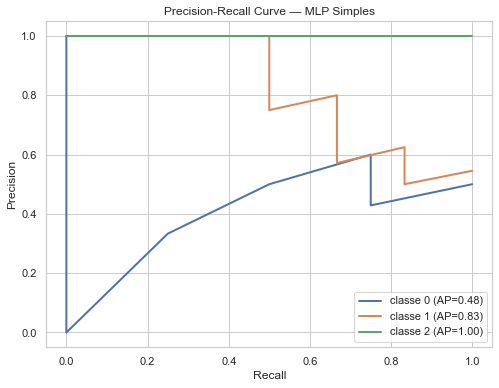

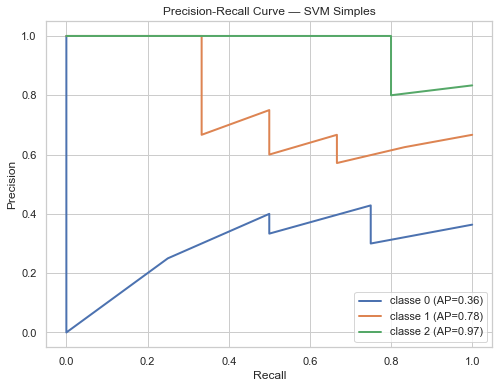

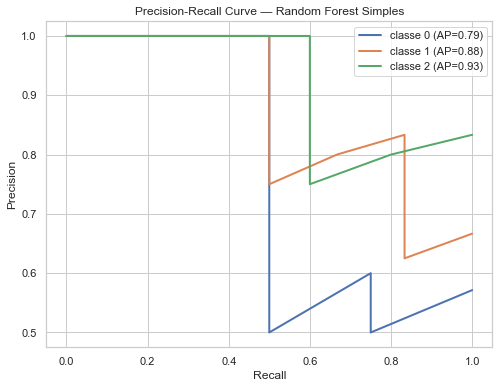

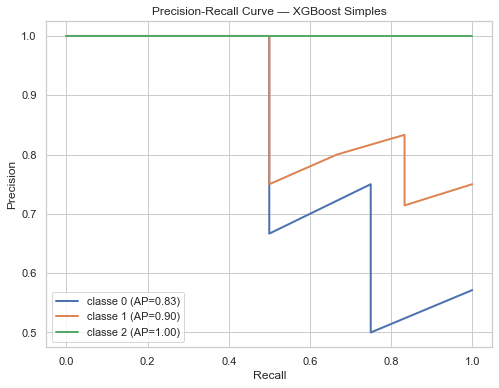

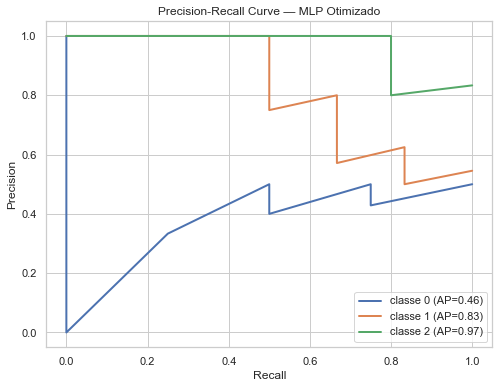

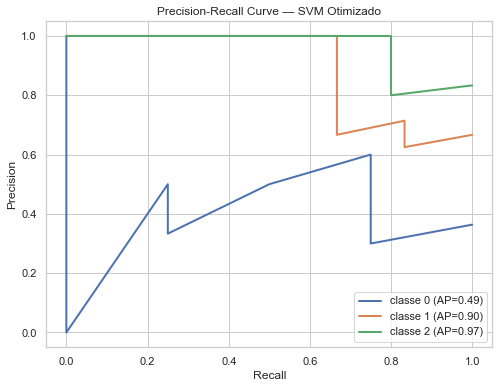

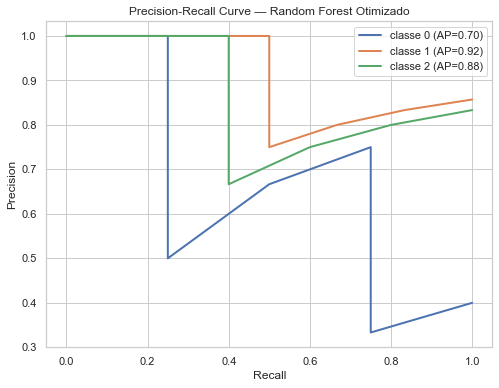

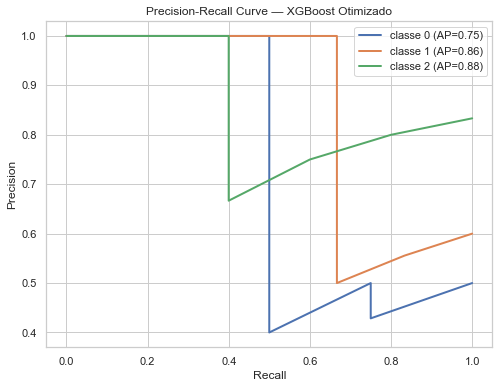

In [196]:
# =========================
# ANÁLISE DOS RESULTADOS - Curvas Precision–Recall multiclass (um gráfico por modelo)
# =========================
plot_precision_recall_multiclass(modelos, X_val, y_val)

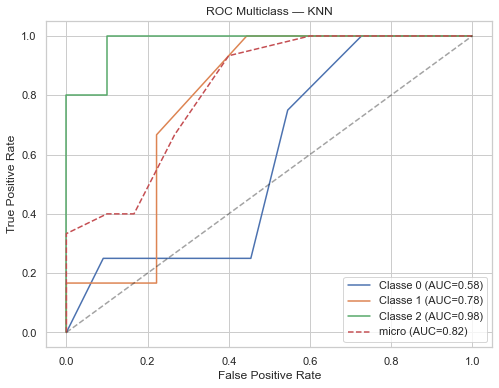

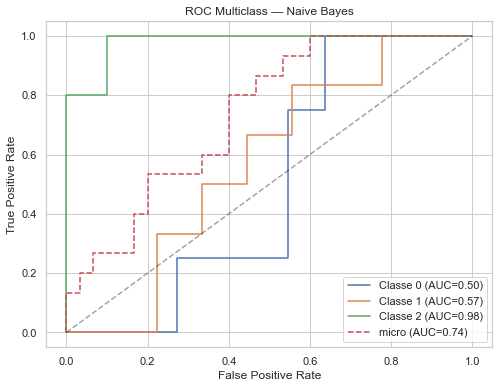

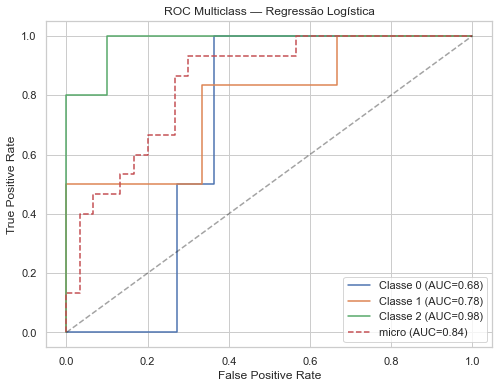

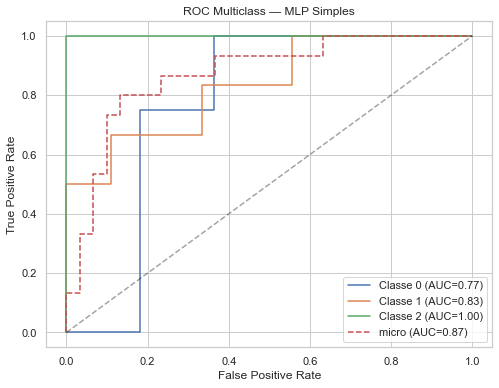

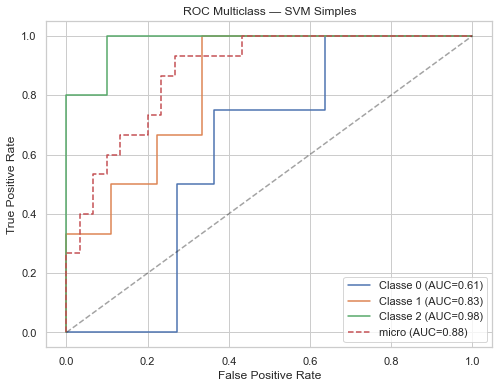

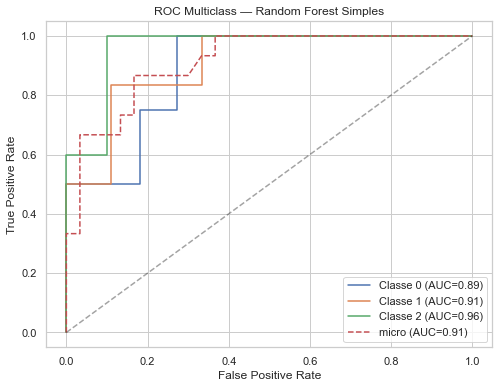

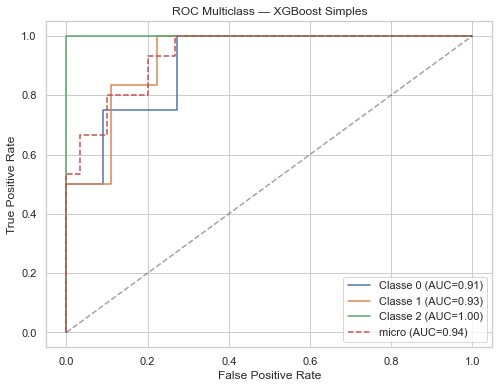

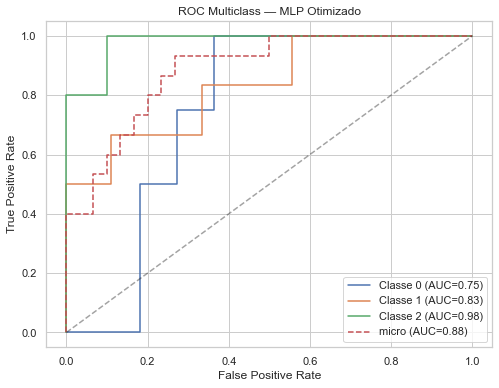

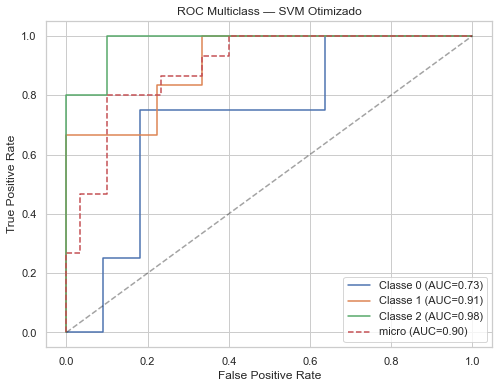

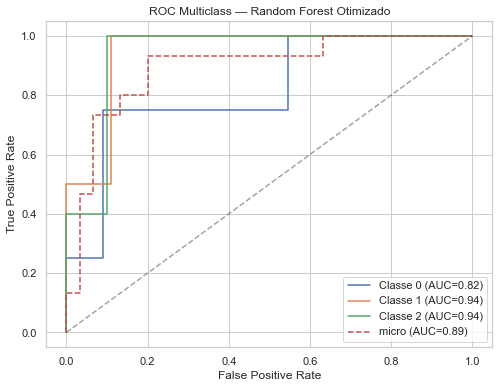

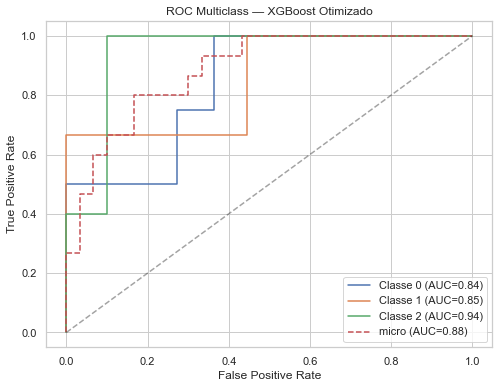

In [197]:
# =========================
# ANÁLISE DOS RESULTADOS - Curvas ROC multiclass
# =========================
plot_roc_multiclass(modelos, X_val, y_val)

In [198]:
# =========================
# ANÁLISE DOS RESULTADOS - Importância de features (para o melhor modelo)
# =========================

# nomes das colunas usadas no treinamento
feature_names = list(X_train.columns)

df_imp = importancia_features_modelo(
    modelo_principal,
    X_val,
    y_val,
    feature_names=feature_names,
    top_k=20
)

df_imp


,feature,importance
0,eda_phasic_mean,0.180000
1,hr_std,0.140000
2,inter_hrv_eda,0.103333
3,eda_mean,0.083333
4,acc_mag_std,0.043333
5,acc_entropy,0.033333
6,bvp_mean,0.030000
7,eda_std,0.026667
8,temp_mean,0.020000
9,inter_eda_temp_mult,0.020000


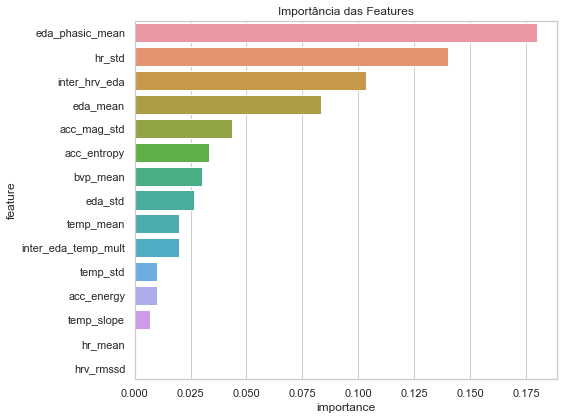

In [199]:
# =========================
# ANÁLISE DOS RESULTADOS - Gráfico de importância das features
# =========================
plot_importancia(df_imp, top_k=15)


In [200]:
# =========================
# ANÁLISE DOS RESULTADOS - Análise de erros por classe
# =========================
erro_df = analise_erros_por_classe(
    modelo_principal,
    X_val,
    y_val,
    feature_df=pd.DataFrame(X_val, columns=feature_names),
    labels=sorted(set(y_val))
)

erro_df


,classe,FN_count,FP_count,TP_count,FN_percent,FP_percent,FN_feature_mean,FP_feature_mean
0,0,1,1,3,0.066667,0.066667,"{'acc_energy': -0.5639102746610248, 'acc_entro...","{'acc_energy': 0.022618147115944526, 'acc_entr..."
1,1,2,0,4,0.133333,0.000000,"{'acc_energy': 0.13211447031541387, 'acc_entro...",{}
2,2,0,2,5,0.000000,0.133333,{},"{'acc_energy': -0.1611497405730708, 'acc_entro..."


In [201]:
gerar_submissao(
    modelo_principal,
    X_test,
    test_ids,
    label_encoder,
    nome_arquivo="submission.csv"
)


--- Gerando arquivo de submissão ---

✅ Submissão salva em: dataset/submission.csv
Ordem das colunas verificada: 0=STRESS, 1=AEROBIC, 2=ANAEROBIC
        Id  Predicted_0  Predicted_1  Predicted_2
0  U_19341     0.828000     0.100000     0.072000
1  U_54670     0.694667     0.162333     0.143000
2  U_21920     0.585000     0.304667     0.110333
3  U_58128     0.216667     0.304333     0.479000
4  U_73365     0.074667     0.625048     0.300286


,Id,Predicted_0,Predicted_1,Predicted_2
0,U_19341,0.828000,0.100000,0.072000
1,U_54670,0.694667,0.162333,0.143000
2,U_21920,0.585000,0.304667,0.110333
3,U_58128,0.216667,0.304333,0.479000
4,U_73365,0.074667,0.625048,0.300286
5,U_89682,0.656667,0.096667,0.246667
6,U_11501,0.933333,0.046667,0.020000
7,U_46423,0.562889,0.329556,0.107556
8,U_71408,0.962000,0.015000,0.023000
9,U_95655,0.325333,0.443667,0.231000
